<a href="https://colab.research.google.com/github/kkb0318/benkyokai/blob/main/PDP_ICE_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 48.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## titanic dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from IPython.display import clear_output
from matplotlib import pyplot as plt

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')




<table>
  <tr>
    <th>Feature Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>sex</td>
    <td>Gender of passenger</td>
  </tr>
  <tr>
    <td>age</td>
    <td>Age of passenger</td>
  </tr>
    <tr>
    <td>n_siblings_spouses</td>
    <td>siblings and partners aboard</td>
  </tr>
    <tr>
    <td>parch</td>
    <td>of parents and children aboard</td>
  </tr>
    <tr>
    <td>fare</td>
    <td>Fare passenger paid.</td>
  </tr>
    <tr>
    <td>class</td>
    <td>Passenger's class on ship</td>
  </tr>
    <tr>
    <td>deck</td>
    <td>Which deck passenger was on</td>
  </tr>
    <tr>
    <td>embark_town</td>
    <td>Which town passenger embarked from</td>
  </tr>
    <tr>
    <td>alone</td>
    <td>If passenger was alone</td>
  </tr>
</table>

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Train and evaluate the model

### Preprocessing

In [4]:
def make_input_fn(X):
  #print(X.isnull().sum())
  X = X.dropna()
  X["sex"] = X["sex"].map({"male":0,"female":1})
  X["alone"] = X["alone"].map({"n":0,"y":1})
  X = pd.get_dummies(X, columns=['embark_town'])
  X = pd.get_dummies(X, columns=['class'])
  X = pd.get_dummies(X, columns=['deck'])
  return X

In [5]:
x_train = make_input_fn(dftrain)
x_eval = make_input_fn(dfeval)

In [6]:
# 足りない列を追加
x_eval[x_train.columns.difference(x_eval.columns)]=0

### Training

In [7]:
clf = RandomForestClassifier(random_state=42,n_estimators=100, max_features=1).fit(x_train, y_train)

In [8]:
predicted = clf.predict(x_eval)

In [9]:
x_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'alone',
       'embark_town_Cherbourg', 'embark_town_Queenstown',
       'embark_town_Southampton', 'embark_town_unknown', 'class_First',
       'class_Second', 'class_Third', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_G', 'deck_unknown'],
      dtype='object')

**精度を出力**
* そもそも精度が悪ければXAIの意味もなくなるので注意（信頼できないモデルに対し推論した理由を聞いても意味がない）
* 今回は精度68%とあまりよくないのでXAIの結果はあくまで参考程度

In [10]:
from sklearn.metrics import confusion_matrix, precision_score
print(confusion_matrix(y_eval,predicted))
print(precision_score(y_eval,predicted))

[[129  36]
 [ 23  76]]
0.6785714285714286


### PDP evaluation

In [11]:
from sklearn.inspection import plot_partial_dependence
%config InlineBackend.figure_format = 'retina'

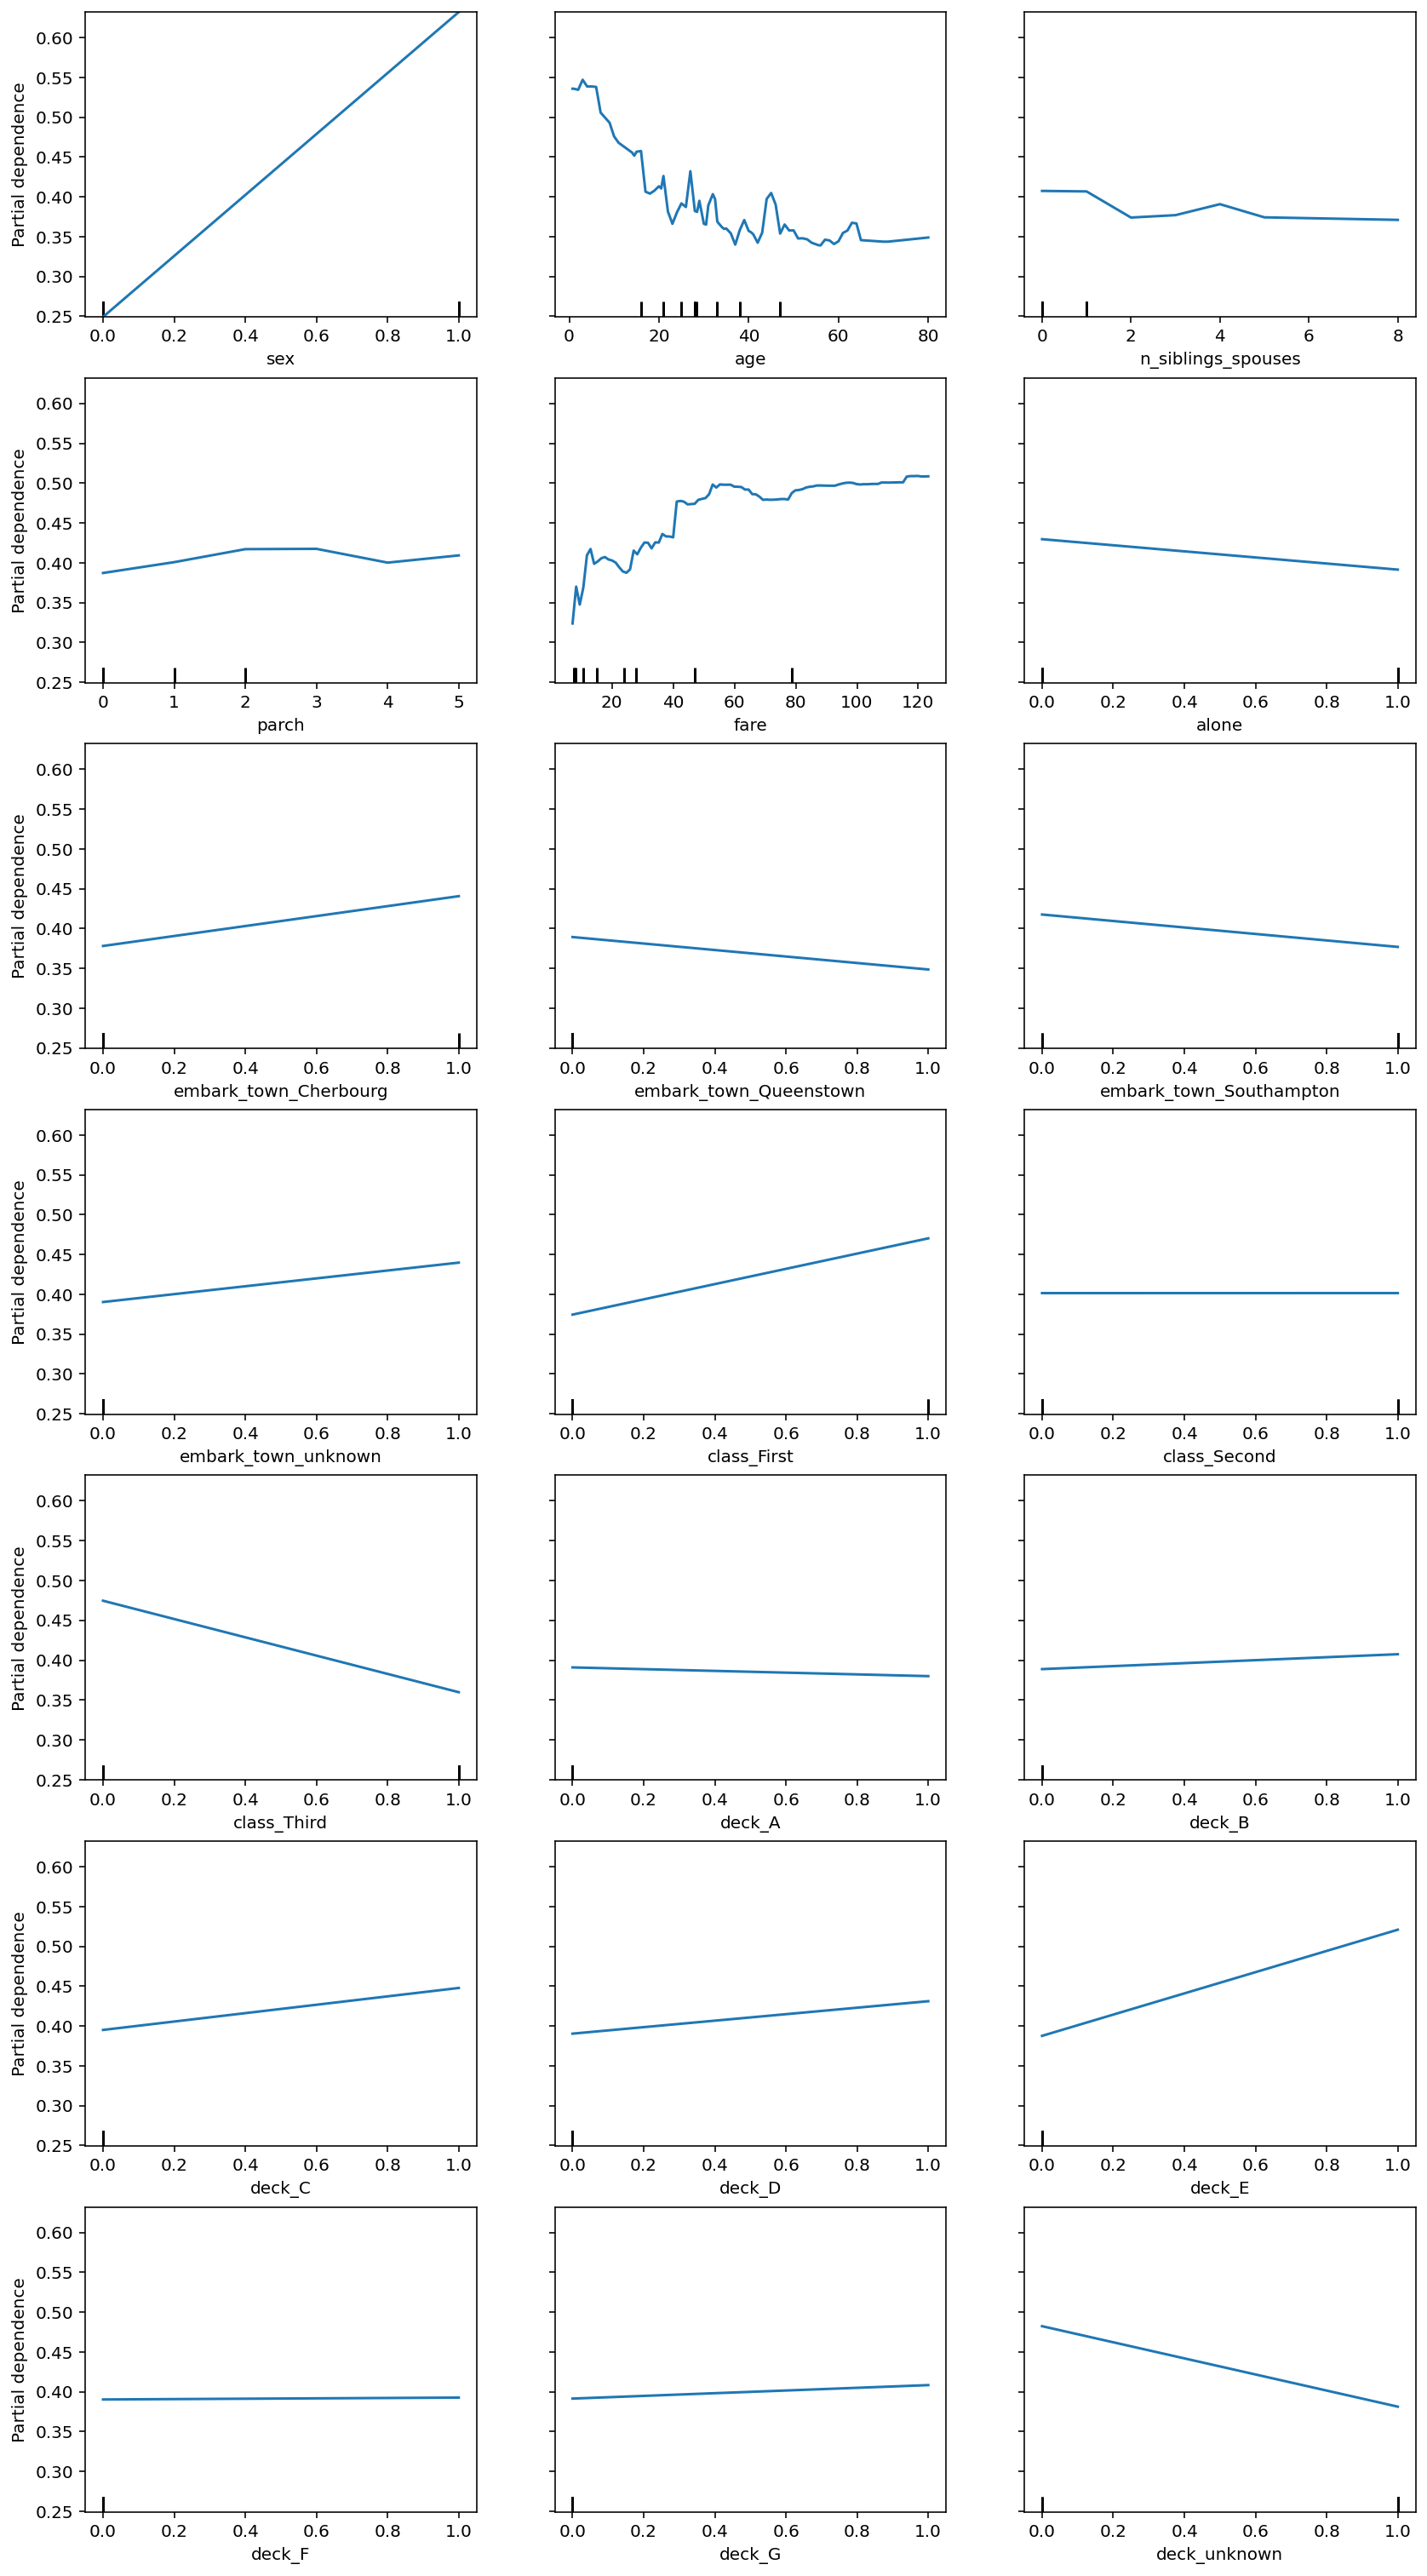

In [12]:
_, ax1 = plt.subplots(7, 3, figsize=(14, 27))

plot_partial_dependence(clf, x_train, features=x_train.columns, target=0, ax=ax1) 

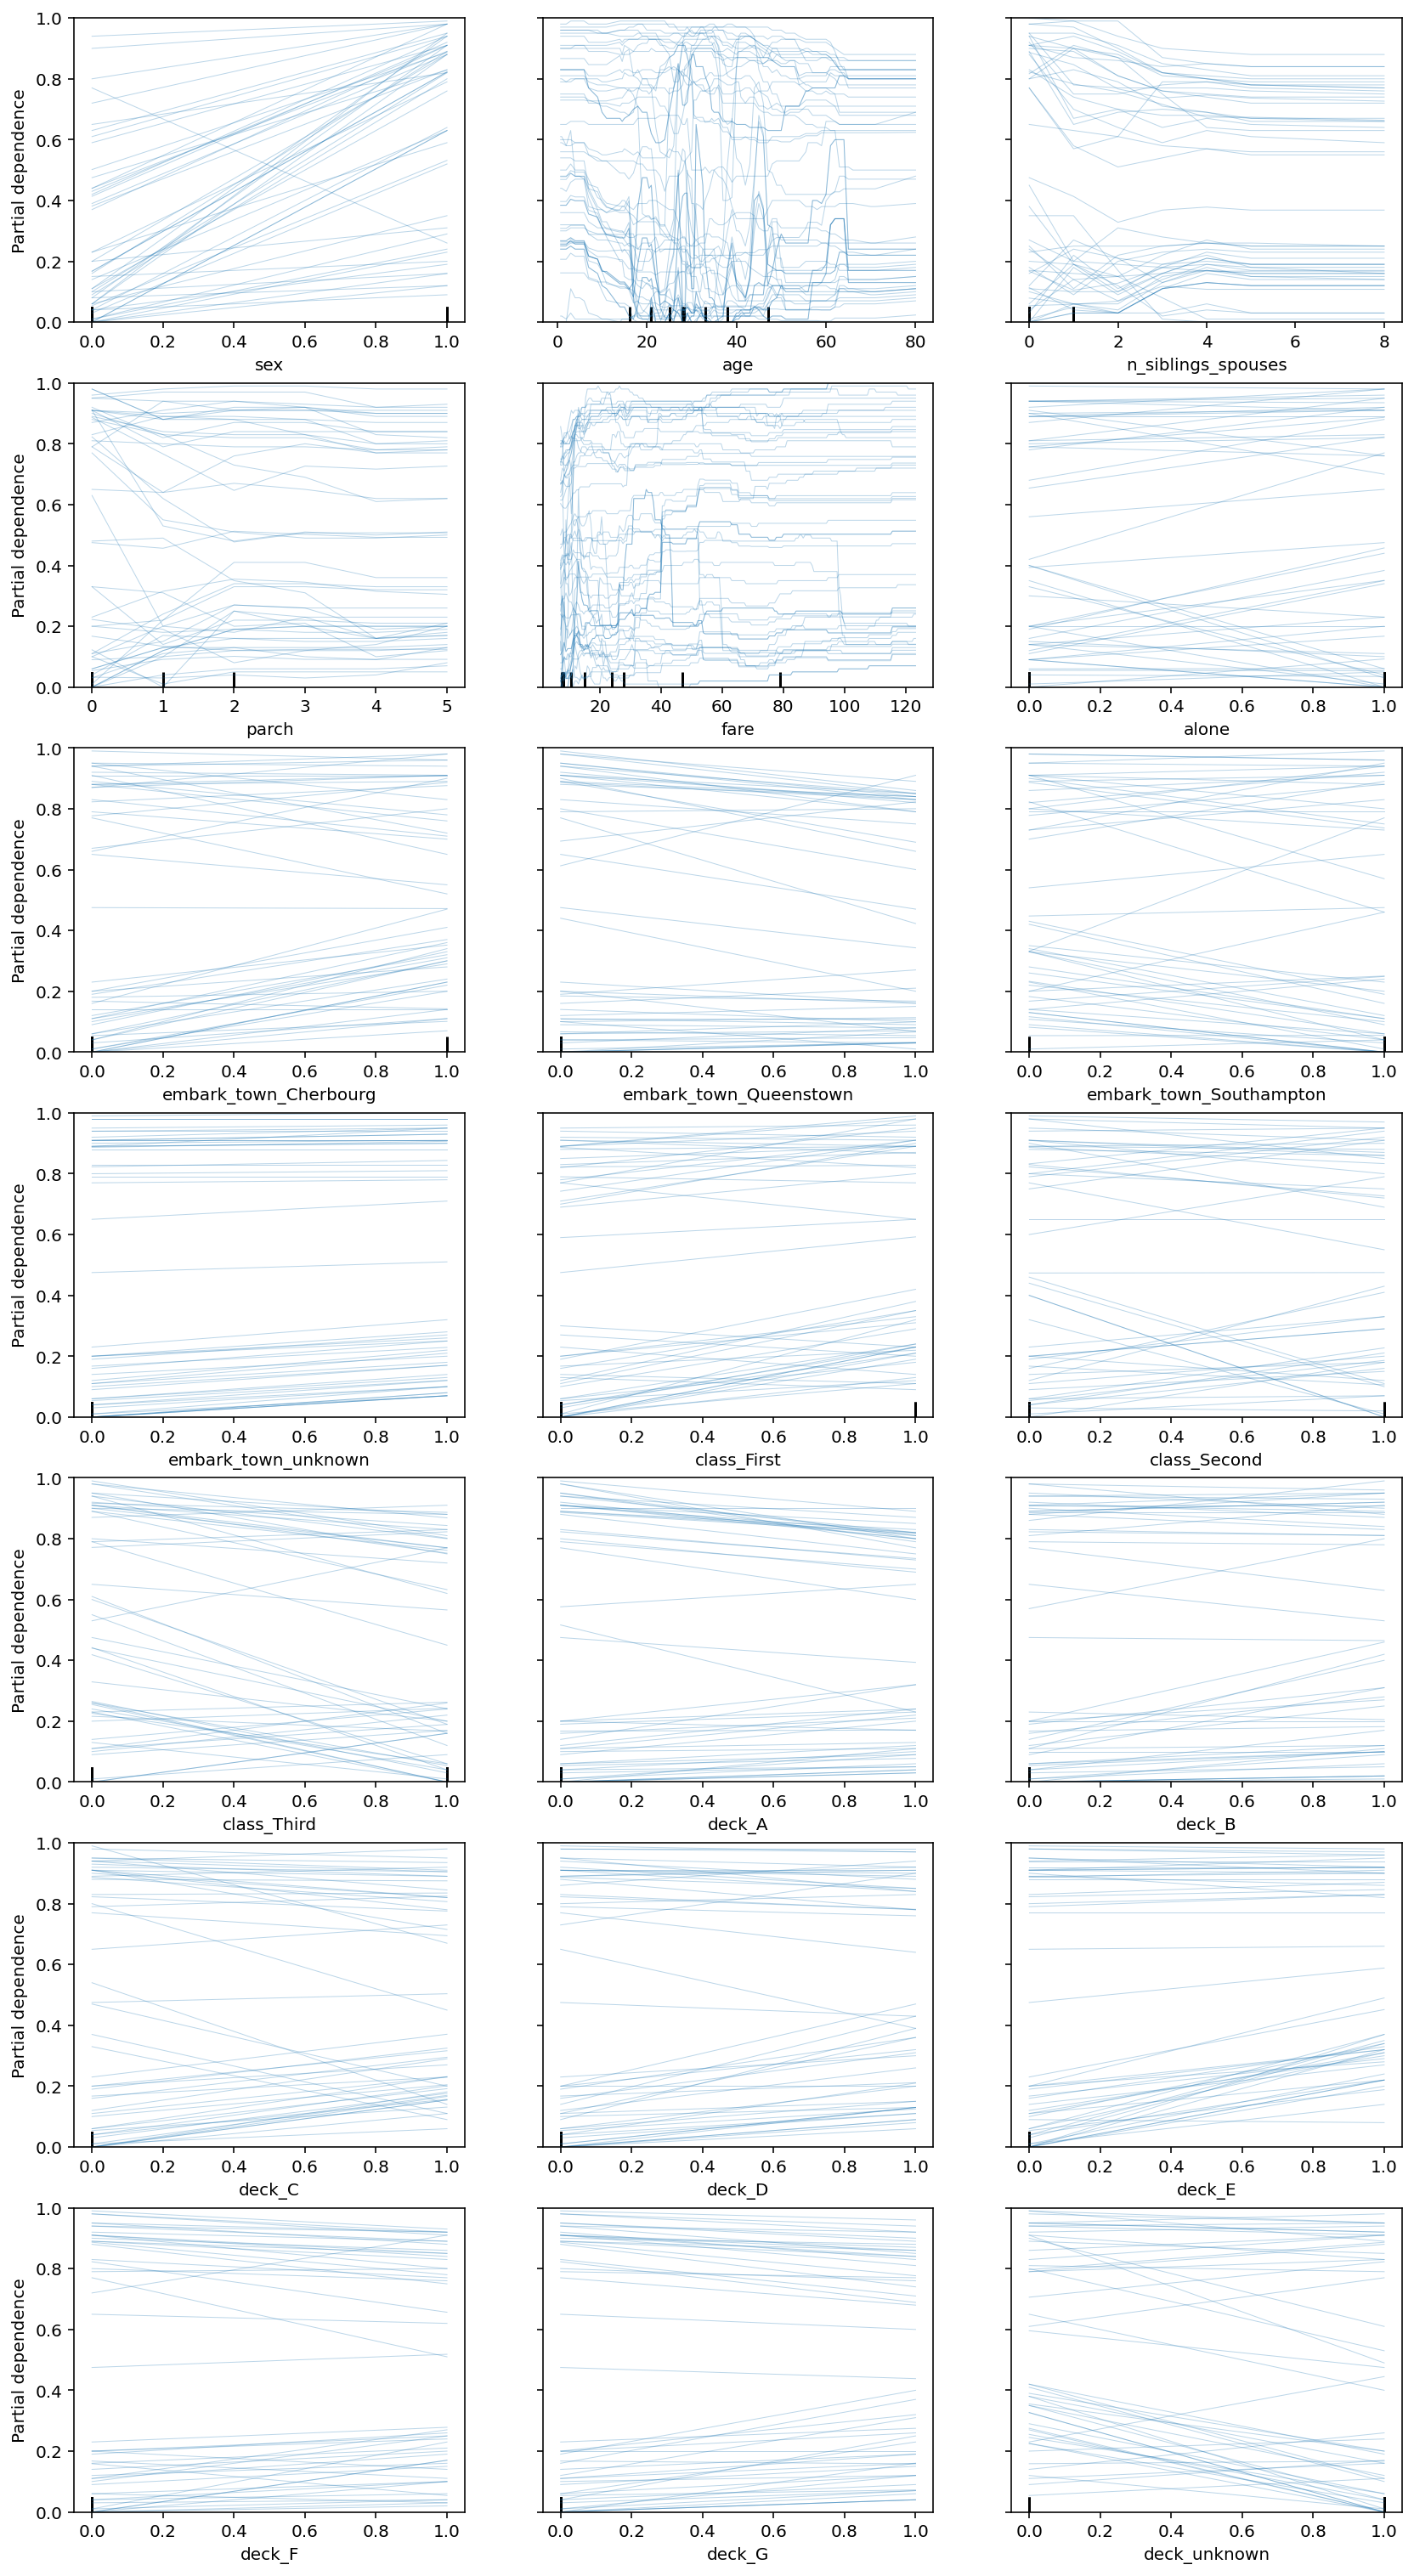

In [14]:
_, ax2 = plt.subplots(7, 3, figsize=(14, 27))
plot_partial_dependence(
       clf, x_train, features=x_train.columns, kind="individual", subsample=50,
       n_cols=7,n_jobs=3, grid_resolution=200, random_state=0, ax=ax2
)